# Classification Lab

Lab 4 [Rubric](https://go.odl.mit.edu/subject/6.036/catsoop/labs/lab04/rubric)

In week 2 we learned about regression which is when our model predicts a continous parameter when given input data, i.e. we go from $\mathbb{R}^d \rightarrow \mathbb{R}$. This week, we will explore models that are useful for when we want to use model to "classify" input data into different discrete categories. These models are appropriately named "classifiers". In this lab, we will explore the simplest classifiers, binary classifiers, which map input vectors $\mathbb{R}^d \rightarrow \{-1, 1\}$, a discrete set with two elements.

In [1]:
# run this cell to load the code for Lab04 and to import libraries
!rm -rf code_and_data_for_lab04*
!rm -rf __MACOSX
!wget --no-check-certificate --quiet https://go.odl.mit.edu/subject/6.036/_static/catsoop/labs/lab04/code_and_data_for_lab04.zip
!unzip code_and_data_for_lab04.zip
!mv code_and_data_for_lab04/* .

Archive:  code_and_data_for_lab04.zip
   creating: code_and_data_for_lab04/
  inflating: __MACOSX/._code_and_data_for_lab04  
  inflating: code_and_data_for_lab04/tokenized_lr_weights.json  
  inflating: __MACOSX/code_and_data_for_lab04/._tokenized_lr_weights.json  


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import json
import pandas as pd

#2) A high dimensional problem we can visualize! Classifying 2D 3-block tetris blocks on a 3x3 grid!

Visualizing hyperplanes in greater than 3 dimensions is hard when you're stuck in 3D. In this example, we show how we can interpret a geometric problem in 2D as a linear logistic classification (LLC) problem in 9D.

Consider a 3x3 gameboard. We can represent this gameboard as a binary 3x3 image, which is just a 3x3 matrix where entries are 0 if a spot on the gameboard is empty or 1 if it is occupied. In this problem, we will use an LLC to identify whether the shape appearing on the gameboard is either a Line (made of 3 blocks in a row) or a Corner (made of 3 blocks that connect to form a small L shape). Each gameboard will be either a Line or a Corner in any given example.

Lines and Corners can appear in multiple locations and orientations on our gameboard to give a total of 22 unique configurations. There are 6 ways to position Lines and 16 ways to position Corners:

Text(-4, 1, 'Corners')

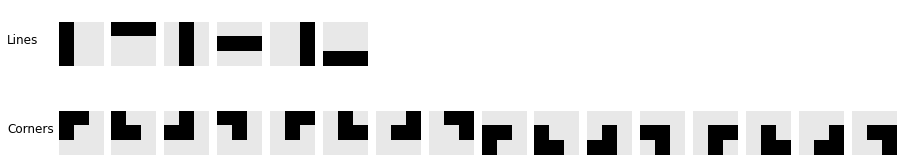

In [3]:
### Create the dataset

empty = np.zeros((3, 3))

# Line pieces (6)
lines = []
for i in range(3):
    line_vert, line_horz = empty.copy(), empty.copy()
    line_horz[i, :] = 1
    line_vert[:, i] = 1
    lines += [line_vert, line_horz]

# L pieces (8)
corners = []
for i in range(2):
  for j in range(2):
    corner1, corner2, corner3, corner4  = empty.copy(), empty.copy(), empty.copy(), empty.copy()
    corner1[[i, i, i+1], [j, j+1, j]] = 1
    corner2[[i, i+1, i+1], [j, j+1, j]] = 1
    corner3[[i+1, i+1, i], [j, j+1, j+1]] = 1
    corner4[[i, i, i+1], [j, j+1, j+1]] = 1
    corners += [corner1, corner2, corner3, corner4]

### Plot the dataset
fig, ax = plt.subplots(nrows=2, ncols=len(corners), figsize=(15,3))
vmin = -0.1  # So empyt shows up as grey 
cmap = 'binary'
for i in range(len(corners)):
  ax[0, i].axis('off')
  ax[1, i].axis('off')
  try:
      ax[0, i].imshow(lines[i], cmap=cmap, vmin=vmin)
  except:
      pass
  ax[1, i].imshow(corners[i], cmap=cmap, vmin=vmin)

ax[0, 0].text(-4, 1, "Lines", fontsize=12)
ax[1, 0].text(-4, 1, "Corners", fontsize=12)

We will use gradient descent to optimize a logistic linear classifier in the homework. For this next exercise we will use the `sklearn.linear.LinearClassifier` and its `.fit` methods. We'll use the L2 regularizer that we've used in class with a starting inverse strength of $C = 1/\lambda = 1.0$ (these are the defaults). 

First, we import `sklearn` and prepare the data!

In [4]:
import sklearn
import sklearn.linear_model

shapes = np.concatenate([lines, corners], axis=0).reshape(-1, 9)  # Flatten 2D 3x3 data into vector
labels = np.array([0,] * len(lines) + [1,] * len(corners))
N = labels.shape[0]

 
Alright! Time to train

In [5]:
sample_weight = None
clf = sklearn.linear_model.LogisticRegression(penalty='l2', C=1.0, random_state=45).fit(shapes, labels, sample_weight=sample_weight)
print("Model accuracy: %.3g" % clf.score(shapes, labels))
decisions = clf.decision_function(shapes)

Model accuracy: 0.727


Okay, what just happened? In this small bit of code, we have both trained and scored our classifier `clf` which is getting just under 73% accuracy. The details of the optimization of the `.fit` method we leave for the homework. But, we can spell out what happens in the `.score` method. 

 * Our classifier's learned parameters are stored in `clf.coef_` and `clf.intercept_` (i.e. $\theta$ and $\theta_0$).

* $\theta$ and $\theta_0$ are used by [clf.decision_function](https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/linear_model/_base.py#L263) to $\theta^T x + \theta_0$...

* ...which is used by [clf.predict](https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/linear_model/_base.py#L295) to predicts the class label (0 if $\text{decision} > 0$ or 1 if $\text{decision} \le 0$). Note, `LogisticClassifier` can be used for multiple classes, not just binary classification, hence why our class labels are positive integers starting at 0.

* Finally, [clf.score](https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/base.py#L475) compares the predicted and true classes to compute the fraction of predictions that are correct

## 2.3) Visualizing the output of our model!

Now, we want to look at how our model is classifying each example. The ultimate output of our model is binary +1 for the gameboard being classified as having a Corner on it and -1 for the gameboard being classified as having a Line on it. However, it can helpful to plot $\theta^T x + \theta_0$ which is the input to the logistic function. $\theta^T x + \theta_0$ indicates whether an example is above or below our decision boundary. The magnitude of this quantity tells us how strongly an example is being classified one way or the other. In the code above, we stored these values in the variable <code>decisions</code>.

We are going to plot the value of $\theta^T x + \theta_0$ (x-axis) for each of our examples on a 1D line. Recall that $\theta^T x + \theta_0 = 0$ is our decison boundary. $\theta^T x + \theta_0 > 0$ means the gameboard will be classified as having a Corner. $\theta^T x + \theta_0 \le 0$ means the gameboard will be classified as having a Line.

In addition to plotting the values of $\theta^T x + \theta_0$, we will also plot which shapes correspond with each data point, grouping them with other shapes that give similar values for $\theta^T x + \theta_0$. We will use colors with different shades to emphasize this grouping.

We will use the y-axis to more clearly separate Corners and Lines. Corners will be displayed above the y-axis and Lines below. Corners classified correctly, will appear in the upper right part of the plot and Lines classified correctly will bottom left part of the plot.


In [6]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap

In [7]:
### Plotting functions ####

def get_groups(decisions):
  unique_decisions = np.sort(np.unique(decisions.round(decimals=4)))
  argwhere_unique_decisions = np.argwhere(decisions.round(decimals=4).reshape(-1, 1) == unique_decisions.reshape(1, -1))
  line_groups = []
  corner_groups = []
  for i, d in enumerate(unique_decisions):
    line_groups.append(np.logical_and(argwhere_unique_decisions[:, 1] == i, labels == 0).nonzero()[0])
    corner_groups.append(np.logical_and(argwhere_unique_decisions[:, 1] == i, labels == 1).nonzero()[0])
  return unique_decisions, line_groups, corner_groups

def imscatter(x, y, shape, ax=None, zoom=1, cmap="binary", vmin=-0.1, vmax=1.0,):
  if ax is None:
      ax = plt.gca()
  im = OffsetImage(shape, zoom=zoom, cmap=cmap)
  x, y = np.atleast_1d(x, y)
  artists = []
  for x0, y0 in zip(x, y):
      ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
      artists.append(ax.add_artist(ab))
  ax.update_datalim(np.column_stack([x, y]))
  ax.autoscale()
  return artists

def plot_decisions(decisions):
  unique_decisions, line_groups, corner_groups = get_groups(decisions)

  fig, ax = plt.subplots(1, 1, figsize=(15,7.5))

  ax.eventplot(np.linspace(-2, 2, 11), orientation='horizontal', colors="#808080",
              lineoffsets=0, linelengths=0.1, linewidths=2,)
  ax.plot([0, 0], [-2, 2], '--', color="#808080")
  ax.plot([-2, 2], [0, 0], '-', color="#808080")

  viridis = ['#fde725', "#5ec962", "#3b528b", "#440154"]
  lighter_viridis = ['#f7efa6', "#b5e8b7", "#8a9ed1", "#cf7be3"]

  ax.scatter(unique_decisions, np.zeros_like(unique_decisions), c=viridis, s=100, zorder=100)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.axes.get_xaxis().set_visible(False)

  imshow_size_w = 0.4
  imshow_size_h = imshow_size_w * 0.4
  spacing = 0.175
  shift_x = - imshow_size_w / 4
  shift_y = 0.2
  zoom = 10

  cols = 2

  for lg, cg, v in zip(line_groups, corner_groups, lighter_viridis):
    cmap = LinearSegmentedColormap.from_list('shifted_binary', [v, "#000000"], N=2)
    for i, s in enumerate(lg):
      imscatter(decisions[s] + (i % cols) * spacing + shift_x, -shift_y - (i // cols) * spacing, shapes[s].reshape(3, 3),
                ax=ax, zoom=zoom, cmap=cmap)
    for i, s in enumerate(cg):
      imscatter(decisions[s] + (i % cols) * spacing + shift_x, shift_y + (i // cols) * spacing, shapes[s].reshape(3, 3),
                ax=ax, zoom=zoom, cmap=cmap)

  ax.set_ylim(-1, 1)

  offset_y = -0.1
  for i in np.linspace(-2, 2, 11):
      ax.annotate('%.1f' % i, (i, offset_y), ha="center", va="center")

  ax.annotate(r"$\theta^T x + \theta_0$", (-2., -0.2), fontsize=20, ha="center", va="center")

  ax.annotate(r"Correctly Classified as Corner", (1, 1), fontsize=20, ha="center", va="center", color="#588c5b")
  ax.annotate(r"Correctly Classified as Line", (-1, -1), fontsize=20, ha="center", va="center", color="#588c5b")
  ax.annotate(r"Misclassified as Line", (-1, +1), fontsize=20, ha="center", va="center", color="#eb7171")
  ax.annotate(r"Misclassified as Corner", (1, -1), fontsize=20, ha="center", va="center", color="#eb7171")

  ax.annotate(r"Corners", (-1.9, 0.5), fontsize=26, ha="center", va="center", rotation=90, color="#b3b3b3")
  ax.annotate(r"Lines", (-1.9, -0.5), fontsize=26, ha="center", va="center", rotation=90, color="#b3b3b3")

  return fig

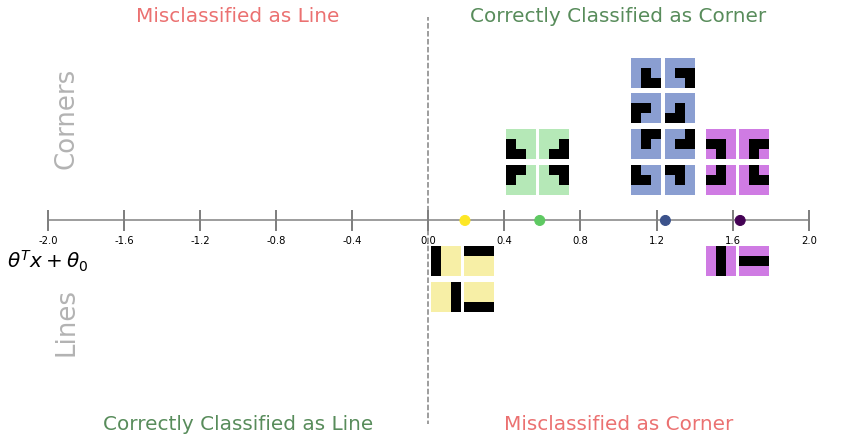

In [ ]:
fig = plot_decisions(decisions)

[Question] Which shapes are being misclassified? Which shapes are being classified correctly? (<u>Misclassifications</u> are shown in the <b>upper left</b> and <b>bottom right</b> parts of the plot and <u>correct classifications</u> are shown in the <b>upper right</b> and <b>bottom left</b> parts of the plot.) 

[Question] In our data, we have many more examples of Corners than Lines. How might this affect our fitted model? 

## 2.4)  Sample weighting carries great weight

Now, let's weight the samples inversely by the number of examples from that class. In other words, if there are 6 examples of class 0 and 16 examples of class 1, class 0 examples will be weighted by 1/6 and class 1 examples by 1/16.

In [8]:
n_lines, n_corners, n_all = len(lines), len(corners), len(lines) + len(corners)
# We are multiplying by n_all because clf will take the mean of our losses (and this divide by n_all).
sample_weight_1 = np.array([1. / (n_lines + n_corners)] * n_all) * n_all
sample_weight_2 = np.array([1. / n_lines] * n_lines + [1. / n_corners] * n_corners) * n_all

clf = sklearn.linear_model.LogisticRegression(penalty='l2', C=1.0, random_state=45).fit(
    shapes, labels, sample_weight=sample_weight_2)
print("Model accuracy: %.3g" % clf.score(shapes, labels))
decisions = clf.decision_function(shapes)

Model accuracy: 0.727


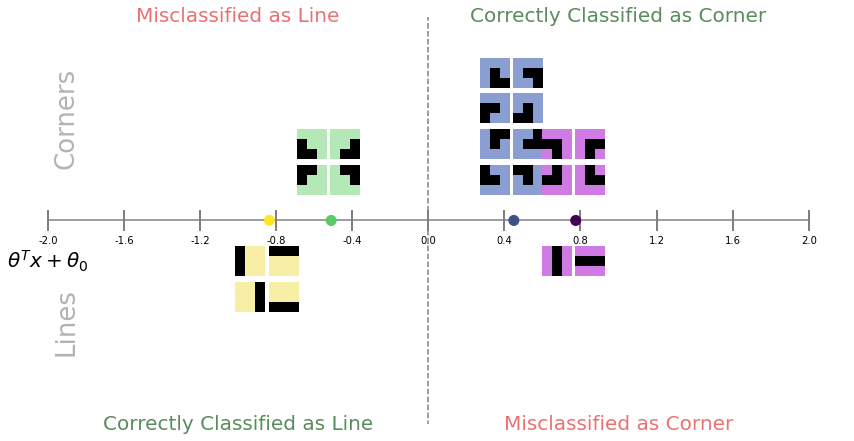

In [9]:
fig = plot_decisions(decisions)

[Question] Now which shapes are being misclassified?

[Question] Are there any trends in $\theta^T x + \theta_0$? What do shapes with the same value of $\theta^T x + \theta_0$ have in common? Which pixels do they have occupied or not occupied?

## 2.5) Model accuracy and predictions as a function of weighting
Model accuracy tells us the fraction of examples that are being correctly classified: 0. means no examples are being correctly classified, 0.5 means half the examples are being correctly classified, and 1.0 means all examples are being correctly classified. 

Below, we will plot the model accuracy and $\theta^T x + \theta_0$ as we continuously vary $p$ in the following expression which linearly interpolates between the two weightings we explored above:

$$a^{(i)} = (1-p) \times \frac{1}{n} + p \times \frac{1}{n^{(i)}_\text{Class}}$$

where $\frac{1}{n} = 1/22$, $\frac{1}{n^{(i)}_{\text{Lines}}} = 1/6$, and $\frac{1}{n^{(i)}_{\text{Corners}}} = 1/16$.

The plot below will show how the value of $\theta^T x + \theta_0$ for the four groups of shapes changes as we interpolate between our two weighting schemes. The colors in this plot match those of the above plots and we will include pictures of the shapes in each group next to the curve that they coorespond to.

In [10]:
def interpolated_weights(p):
  sample_weight_1 = np.array([1. / (n_lines + n_corners)] * n_all) * n_all
  sample_weight_2 = np.array([1. / n_lines] * n_lines + [1. / n_corners] * n_corners) * n_all
  return (1 - p) * sample_weight_1 + p * sample_weight_2

In [11]:
n = 500
ps = np.linspace(0, 1, n)
scores = []
decisions_vs_p = []
for p in ps:
  clf = sklearn.linear_model.LogisticRegression(penalty='l2', C=1., random_state=45).fit(
      shapes, labels, sample_weight=interpolated_weights(p))
  decisions_vs_p.append(clf.decision_function(shapes))
  scores.append(clf.score(shapes, labels))
decisions_vs_p = np.stack(decisions_vs_p, axis=0)

In [12]:
def plot_decisions_vs_p(decisions_vs_p):
  fig = plt.figure(figsize=(8,8))
  gs = GridSpec(3, 1, figure=fig)
  ax0 = fig.add_subplot(gs[0:2, 0])
  ax1 = fig.add_subplot(gs[2, 0])
  ax = [ax0, ax1]
  n = decisions_vs_p.shape[-1]

  ax[1].set_xlim(0, 1)
  ax[0].set_xlim(0, 1)
  ax[1].set_ylim(0, 1)
  example_shapes = [0, 6, 7, 2]

  ax[0].set_ylabel(r"$\theta^T x + \theta_0$", fontsize=18)
  ax[0].set_xticklabels([""] * len(ax[0].get_xticks()))

  ax[1].set_ylabel("Model Accuracy", fontsize=14)
  ax[1].set_xlabel("Weighting parameter $p$", fontsize=14)
  ax[1].plot(ps, scores, 'k-', label='Model accuracy')
  ax[0].plot([0, 1], [0, 0], 'k--', label="Hyperplane", color="#878787")

  viridis = ['#fde725', "#5ec962", "#3b528b", "#440154"]
  lighter_viridis = ['#f7efa6', "#b5e8b7", "#8a9ed1", "#cf7be3"]
  unique_decisions, line_groups, corner_groups = get_groups(decisions_vs_p[0])

  imshow_size_w = 0.4
  imshow_size_h = imshow_size_w * 0.4
  spacing_x = 0.06
  spacing_y = 0.05
  shift_x = - imshow_size_w / 4
  shift_y = 0.03
  zoom = 8

  cols = 1

  ys = [-0.5, 0.7, 0.27, 1.2]
  xs = [0.225, 0.225, 0.97, 0.97]
  for lg, cg, v, x, y in zip(line_groups, corner_groups, lighter_viridis, xs, ys):
    g = np.concatenate([lg, cg], axis=0)
    cmap = LinearSegmentedColormap.from_list('shifted_binary', [v + 'AA', "#000000" + 'AA'], N=2)
    for i, s in enumerate(g):
      imscatter(x - (i // cols) * spacing_x, y, shapes[s].reshape(3, 3),
                ax=ax[0], zoom=zoom, cmap=cmap)

  ax[0].set_xlim(0, 1)

  for j, i in enumerate(example_shapes):
    ax[0].plot(ps, decisions_vs_p[:, i], '-', 
               color=viridis[j])
  return fig

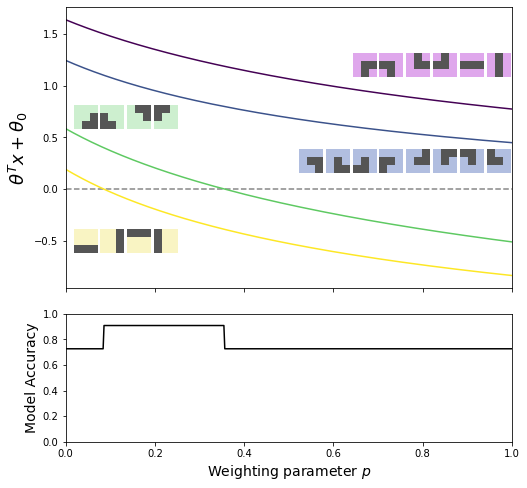

In [ ]:
plot_decisions_vs_p(decisions_vs_p);

**2.5.1)** What value or range of $p$ gives us the most accurate model?

**2.5.2)** Let's take a closer look to what's happening at the model accuracy transition. Which values are crossing the decision boundary for the values of $p$ that give the most accurate models. 

**2.5.3)** For this model, which examples are being incorrectly classified? Which examples are being correctly classified?

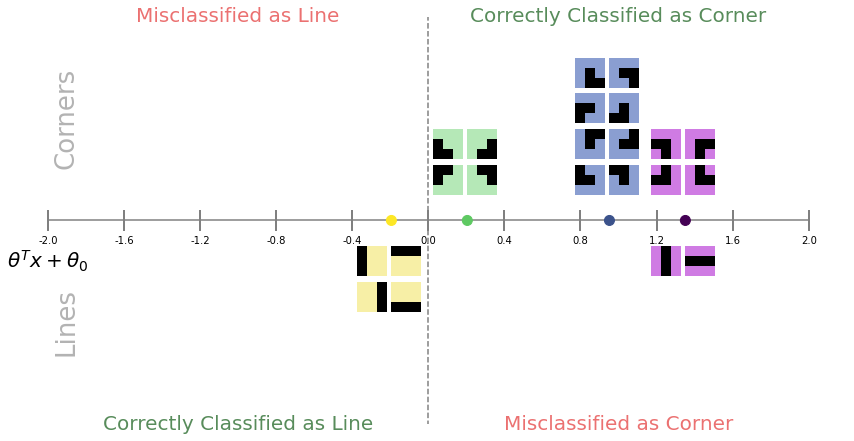

In [13]:
plot_decisions(decisions_vs_p[int(0.2 * n)]);

## 2.6) Visualizing $\theta$

Let's plot the 9 parameters of $\theta$ of the model trained for $p=0.2$ as a 3x3 grid. We will plot parameters that contribute to an example being classified as a Line (negative parameters) on the left and parameters that contribute to an example being classified as a Corner (positive parameters) on the right. Darker pixels means more important for that classification. Which pixels are most important for each classification? How do these patterns match the shapes that are being classified as Lines vs. Corners? 

In [14]:
clf = sklearn.linear_model.LogisticRegression(penalty='l2', C=1., random_state=45).fit(
    shapes, labels, sample_weight=interpolated_weights(0.2))

print("Model accuracy: %.3g" % clf.score(shapes, labels))
decisions = clf.decision_function(shapes)

Model accuracy: 0.909


Text(0.5, 0, '|$\\theta$|')

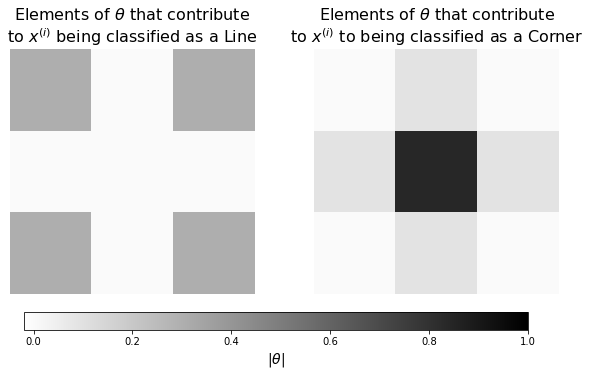

In [15]:
theta = clf.coef_

contributes_to_corner_class = np.where(theta > 0, theta, 0)
contributes_to_line_class = np.abs(np.where(theta < 0, theta, 0))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vmax = 1
ax[0].imshow(contributes_to_line_class.reshape(3, 3),  cmap="binary", vmin=-0.02, vmax=vmax)
ax[0].set_title(r"Elements of $\theta$ that contribute"+ "\n" + r"to $x^{(i)}$ being classified as a Line", fontsize=16)

ax[0].axis('off')

im = ax[1].imshow(contributes_to_corner_class.reshape(3, 3),  cmap="binary", vmin=-0.02, vmax=vmax)
ax[1].set_title(r"Elements of $\theta$ that contribute"+ "\n" + r"to $x^{(i)}$ to being classified as a Corner", fontsize=16)
ax[1].axis('off')

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.05])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar_ax.set_xlabel(r"|$\theta$|", fontsize=14)

In [16]:
contributes_to_corner_class

array([[0.        , 0.09434855, 0.        , 0.09434855, 0.84139945,
        0.09434855, 0.        , 0.09434855, 0.        ]])

#3) Food for thought: A classification example
The code for this problem loads weights from a pretrained logistic regression model that was trained on a subset of available restaurant reviews. The model classifies reviews as positive or negative. A word assigned a more positive value will contribute towards a positive prediction, and a word assigned a negative value will contribute a negative prediction.

In [17]:
weights = json.loads(open('tokenized_lr_weights.json').read())

To understand the behavior of the model, please use the following functions: `get_weight`, `get_bool_sentiment`, and `print_sentiment_table`.

*   The `get_weight` function returns the weight of a single word in the dictionary. If the word is not in the dictionary, the function will return a `KeyError`.
*   The `get_bool_sentiment` function returns a Boolean of whether a single word has positive (`True`) or negative (`False`) sentiment.
*   The `print_sentiment_table` function prints the Boolean sentiments of a list of words in a table for easier comparison.


In [18]:
def get_weight(w):
    out = None
    if w in weights.keys():
        out = weights[w]
    else:
        KeyError("word not in dictionary")
    return out

In [19]:
def get_bool_sentiment(w):
    weight = get_weight(w)
    assert weight is not None
    return weight > 0

In [20]:
def print_sentiment_table(words):
    table = {}
    for w in words:
        positive = get_bool_sentiment(w)
        binary_sentiment = "negative"
        if positive:
            binary_sentiment = "positive"
        table[w] = binary_sentiment
    df =  pd.DataFrame(table.items(), columns=['word', 'binary_sentiment'])
    print(df)

In [21]:
WORDS = ["yummy", "indian", "mexican", "italian", "chinese", "european", "average", "disgusting", "warm", "cold", "gross"]

In [22]:
# Logistic regression table for WORDS
print_sentiment_table(WORDS)

          word binary_sentiment
0        yummy         positive
1       indian         positive
2      mexican         positive
3      italian         positive
4      chinese         negative
5     european         negative
6      average         negative
7   disgusting         negative
8         warm         positive
9         cold         positive
10       gross         negative


### Line Plot of Weights for Different Words
The plot_word_weights plots the logistic regression weights on a 1D plot.

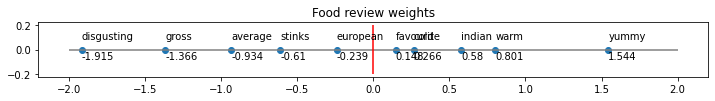

In [23]:
# Make plot with weights labeled in a line plot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
plotted_words = ["yummy", "favourite", "stinks", "indian", "european", "average", "disgusting", "warm", "cold", "gross"]

def plot_word_weights(words):
    plotted_word_weights = [get_weight(w) for w in plotted_words]
    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(1)
    ax.set_title("Food review weights")

    xmin = np.min(plotted_word_weights) - 0.1
    xmax = np.max(plotted_word_weights) + 0.1
    ax.hlines(0, xmin=-2, xmax=2.0, color="grey")
    ax.scatter(plotted_word_weights, np.zeros(len(plotted_words)))
    offset = 0.08
    for i, word in enumerate(plotted_words):
        weight = plotted_word_weights[i]
        ax.annotate(word, (weight, offset))
        ax.annotate(round(weight, 3), (weight, -offset))
    ax.vlines(0, ymin=-0.2, ymax=0.2, color="red")

plot_word_weights(plotted_words)
